# Transfer Leaning

## 1.3.2 폴더준비 

data를 만들고 hymenotera data를 다운로드


In [ ]:
data_path =  "drive/MyDrive/ColabData/chap1/"

In [ ]:
!wget "https://download.pytorch.org/tutorial/hymenoptera_data.zip" -O hymenoptera_data.zip
!unzip -o hymenoptera_data.zip
!rm hymenoptera_data.zip
!mv -f hymenoptera_data $data_path

--2022-01-12 02:15:53--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.204.49, 13.32.204.34, 13.32.204.93, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.204.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  37.8MB/s    in 1.2s    

2022-01-12 02:15:54 (37.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tr

In [ ]:
import glob
import os.path as osp
import random 
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
import torch  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader 
import torchvision 
from torchvision import models,transforms

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.3.5 Dataset 작성

In [ ]:

# 입력 화상의 전처리 클래스 
# 훈련시와 추론시 처리가 다르다

class ImageTransform():
    """
    화상 전처리 클래스, 훈련,검증 시의 동작이 다름
    화상 크기를 리사이즈하고 색상을 표준화
    훈련시에는 RandomResizedCrop, RandomHorizontalFlip으로 데이터를 확장한다.

    Attributes
    ---------------
    resize:int 리사이즈 대상 화상의 크기
    mean: (R,G,B) 각 채널값의 평균
    std:(R,G,B) 각 채널값의 표준편차
    """

    def __init__(self,resize,mean,std):
        self.data_transform = {
            'train': transforms.Compose([
            transforms.RandomResizedCrop(
                resize,scale=(0.5,1.0)), # 데이터 확장
            transforms.RandomHorizontalFlip(),# 데이터 확장
            transforms.ToTensor(), # 텐서로 변환
            transforms.Normalize(mean,std) # 표준화                     
            ]),
            'val': transforms.Compose([
            transforms.Resize(resize), # resize
            transforms.CenterCrop(resize), # 화상 중앙을 resiez x resize로 자른다
            transforms.ToTensor(), # 텐서로 변환
            transforms.Normalize(mean,std) # 표준화                     
            ])
        }
    def __call__(self,img,phase="train"):
      return self.data_transform[phase](img)


In [ ]:
def make_datapath_list(phase="train"):
    """
    데이터의 경로를 저장한 리스트 작성
    """
    root_path = "hymenoptera_data/"
    target_path = osp.join(data_path+root_path+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

In [ ]:
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

drive/MyDrive/ColabData/chap1/hymenoptera_data/train/**/*.jpg
drive/MyDrive/ColabData/chap1/hymenoptera_data/val/**/*.jpg


In [ ]:
train_list[:10]

['drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/0013035.jpg',
 'drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 'drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg',
 'drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg',
 'drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/116570827_e9c126745d.jpg',
 'drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg',
 'drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/1262877379_64fcada201.jpg',
 'drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg',
 'drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg',
 'drive/MyDrive/ColabData/chap1/hymenoptera_data/train/ants/132478121_2a430adea2.jpg']

In [ ]:
class HymenopteraDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(
            img, self.phase
        )
        
        if self.phase == 'train':
            label = img_path[30+23:34+23]
        elif self.phase == 'val':
            label = img_path[28+23:32+23]
            
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
            
        return img_transformed, label

In [ ]:
mean = (0.485, 0.456, 0.406) #image net data 의 평균
std = (0.229, 0.224, 0.225) # .. 표준편차

In [ ]:
train_dataset = HymenopteraDataset(
    file_list=train_list,
    transform=ImageTransform(224, mean, std),
    phase='train'
)

val_dataset = HymenopteraDataset(
    file_list = val_list,
    transform=ImageTransform(224, mean, std),
    phase='val'
)

0


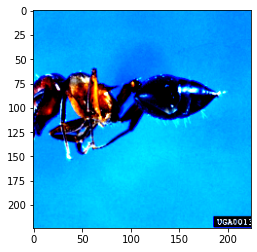

torch.Tensor

In [ ]:
index = 0
img, label = train_dataset[index]
print(label)
#img.permute(1,2,0) |> torch.clip$(?, 0, 1) |> plt.imshow
img = img.permute(1,2,0)
img = torch.clip(img, 0, 1)
plt.imshow(img)
plt.show()

## 1.3.6 DataLoader 작성

In [ ]:
batch_size = 32

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
)

dataloaders_dict = {
    "train": train_dataloader,
    "val": val_dataloader,
}

In [ ]:
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

In [ ]:
net = models.vgg16(pretrained=True)

print(net.classifier)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

print("네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.")

In [ ]:
net.classifier

## 1.3.8 LossFruction 정의

In [ ]:
criterion = nn.CrossEntropyLoss()

## 1.3.9 Opimization 정의

In [ ]:
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
        
print("--------------")
print(params_to_update)

In [ ]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## 1.3.10 Train & Validation

In [ ]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            # To check validate performance
            if (epoch == 0) and (phase == 'train'):
                continue
            
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, dim=1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() + inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

In [ ]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

In [ ]:
img_t, label = val_dataset[7]
img = img_t.permute(1,2,0)
img = img.clip(0, 1)
plt.imshow(img)
plt.show()
print(label)

In [ ]:
net.eval()
pred = torch.max(net(img_t.unsqueeze(0)), dim=1)[1].item()
if pred == 0:
    print("Ant!")
elif pred == 1:
    print("Bee!")